## Часть вторая

In [24]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [162]:
import psycopg2
import pandas as pd
import pymongo
import sqlalchemy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib as mpl
from datetime import datetime, timedelta
import numpy as np
import requests
import re
import seaborn as sns

In [163]:
# создадим функцию, чтобы отправлять JSON-запросы к API VK

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response


In [164]:
# получаем последнюю запись из паблика Skillbox Вконтакте
''
vk_token = # здесь секретный токен

url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=1&v=5.92'
response2 = getjson(url)


In [165]:
# сдвигаем запрос и получаем запись из паблика Skillbox Вконтакте на 27 ноя в 19:38 (про черную пятницу, offset=10)
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=10&count=1&v=5.92'
response3 = getjson(url)


In [166]:
# сдвигаем запрос и получаем запись из паблика Skillbox Вконтакте на 27 ноя в 19:38 (про черную пятницу, offset=10)
#и ещё 31 записей назад (count=31)

url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=10&count=31&v=5.92'
response3 = getjson(url)


**Примечание**

В качестве объекта анализа я решила выбрать посты со стены паблика Skillbox за период c 02 ноября 2020 года по 27 ноября 2020 года (так как это день больших скидок - большое событие), т.е. за 31 день. 
Мне кажется, что за этот период SMM-отдел подготовил большое количество рекламных постов в поддержку большой акции на "Черную Пятницу", проверим эту **гипотезу**.

In [212]:
# преобразуем вложенный файл JSON в датафрейме за выбранный период c помощью pd.json_normalize

df = pd.json_normalize(response3['response']['items'])
df.head(3)

,id,from_id,owner_id,date,marked_as_ads,post_type,text,attachments,is_favorite,comments.count,likes.count,reposts.count,views.count
0,127212,-66669811,-66669811,1606491528,0,post,Пятница — любимый день недели? А если она Черн...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,0,25,2,22158
1,126629,-66669811,-66669811,1606408803,0,post,"Приложения — это инструменты, которые помогают...","[{'type': 'link', 'link': {'url': 'https://ski...",False,2,83,21,22141
2,126596,-66669811,-66669811,1606387615,0,post,После учебы или работы очень важно хорошенько ...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,5,167,16,33024


In [232]:
# сохраним полученный датафрейм, чтобы не было необходимости использовать токен для обращения к анализируемому периоду

df.to_csv('df.csv')


In [2]:
# загрузим содержимое файла df.csv

df = pd.read_csv('df.csv')

In [3]:
# создадим новый датафрейме, оставив только те столбцы, которые нас интересуют для анализа

df1= df[['date', 'text', 'comments.count', 'likes.count','reposts.count','views.count']]
df1.head(3)

,date,text,comments.count,likes.count,reposts.count,views.count
0,1606491528,Пятница — любимый день недели? А если она Черн...,0,25,2,22158
1,1606408803,"Приложения — это инструменты, которые помогают...",2,83,21,22141
2,1606387615,После учебы или работы очень важно хорошенько ...,5,167,16,33024


In [145]:
# преобразуем дату и время с помощью вызова функций и класса datetime

def date(date):
    return (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d')

# отдельно найдем количество часов для удобства расчетов для  дальнейшего анализа

def hour(date):
    return (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%H')


In [146]:
# создадим новый датафрейм для добавления

df2 = df1.copy()

# применям наш метод и меняем столбец с датой

df2['dates'] = df2['date'].apply(date)
df2['hour'] = df2['date'].apply(hour)

df2.head(3)

,date,text,comments.count,likes.count,reposts.count,views.count,dates,hour
0,1606491528,Пятница — любимый день недели? А если она Черн...,0,25,2,22158,2020-11-27,19
1,1606408803,"Приложения — это инструменты, которые помогают...",2,83,21,22141,2020-11-26,20
2,1606387615,После учебы или работы очень важно хорошенько ...,5,167,16,33024,2020-11-26,14


In [147]:
# удалим теперь не нужный для нас столбец date

del df2['date']

In [148]:
# переименуем столбцы

df2 = df2 \
.rename(columns={'comments.count':'comments', 'likes.count':'likes', 'reposts.count':'reposts', 'views.count':'views'})

In [149]:
# найдем медианные значения по нашему столбцам

df2.median()

comments        2.0
likes          51.0
reposts         6.0
views       24471.0
hour           18.0
dtype: float64

In [150]:
# отберем публикации, которые собрали просмотров больше, чем медианное значение

v = df2.query('views  > 24471').sort_values('views',ascending=False)
v

,text,comments,likes,reposts,views,dates,hour
29,"У диджитал-эпохи много плюсов, всех не перечис...",23,518,94,89953,2020-11-02,18
28,"Главный закон веб-разработки: “То, что выгляди...",28,127,19,77600,2020-11-02,20
30,Придумали лекарство от грусти в самый хмурый м...,13,119,10,61486,2020-11-02,15
10,Coca-Cola славится своими атмосферными новогод...,41,442,36,37604,2020-11-22,15
2,После учебы или работы очень важно хорошенько ...,5,167,16,33024,2020-11-26,14
11,"Любите настольные игры, но сейчас стараетесь д...",7,132,15,31857,2020-11-21,15
14,Артхаус ассоциируется с чем-то скучным и непон...,14,188,28,30598,2020-11-20,14
26,У нас лекций в ноябре хоть отбавляй! Но отбавл...,0,51,2,28713,2020-11-12,19
21,Нужна встряска для воображения? Ловите! Серия ...,2,217,20,27810,2020-11-16,18
19,"Для тех, кому на удаленке не хватает офисной а...",14,120,11,27090,2020-11-17,18


**Вывод 1:**

Видим, что первые три публикации собрали аномально высокий интерес у пользователей и опубликованы они в один день "2020-11-02". Это подозрительно.
Проверим содержание постов и комментариев, возможно, эти данные помогут понять почему такой высокий интерес к публикациям именно в этот день.


In [151]:
# найдём публикации с какими именно содержанием и тегами были "2020-11-02"

text02 = df2.query('dates  == "2020-11-02"')
text02['text'].tolist()

['Главный закон веб-разработки: “То, что выглядит как нормальный сайт и вроде бы работает как нормальный сайт — не обязательно нормальный сайт!”\n\nРазбираемся с валидацией HTML-кода. \n\n#Статья_Skillbox #Skillbox_Программирование',
 'У диджитал-эпохи много плюсов, всех не перечислить. Но есть и обратная сторона — синдром компьютерного зрения.\n\nСделайте паузу — проведите небольшую тренировку для глаз. В карточках собрали упражнения: выполняйте их по очереди или комбинируйте на свое усмотрение. Для большей эффективности повторяйте 5-6 раз в день. Так вы не только сохраните, но даже улучшите зрение.\n\n#В_Закладки_Skillbox',
 'Придумали лекарство от грусти в самый хмурый месяц в году 😁 Включайте наши вебинары и радуйтесь новым знаниям! На этой неделе проведем интенсив по ландшафтному дизайну, научим настраивать и запускать рекламу в Инстаграме и соберем приложение для работы с данными о погоде и экономике.\n\nЖдем вас! \n\nВыбирайте интересующие вебинары и подключайтесь: \n👉 https://v

**Вывод 2:**

На первый взгляд, ничего особенного по содержанию и тегам в постах за "2020-11-02" нет. 
Но если проверить комментарии в "живую" непосредственно VK, то всё сразу становится понятно. В этот период в СМИ появилась информация о пропаже сооснователя Skillbox. 
Видимо, подписчики искали информацию о случившемся на странице Skillbox.
Удалим данные за этот день, чтобы анализ был более объективным.

In [152]:
# отбросим данные за 2020-11-02 

cases=df2[df2['dates'] != '2020-11-02'].dropna()

In [153]:
# пересчитаем медиану

cases.median()

comments        2.0
likes          50.5
reposts         5.0
views       24309.5
hour           18.0
dtype: float64

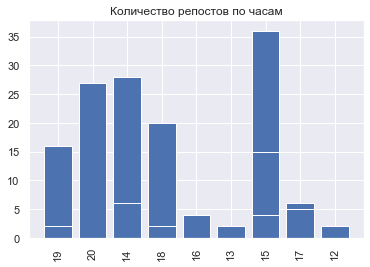

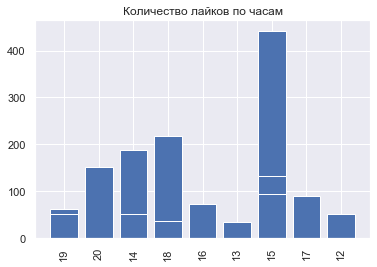

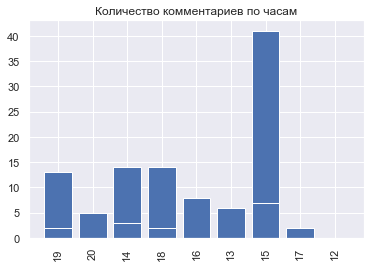

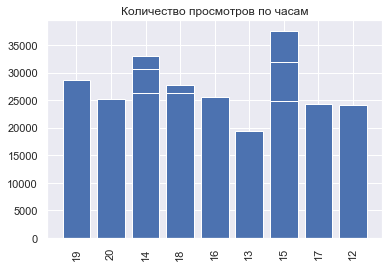

In [156]:
# построим графики

fig, subplot = plt.subplots()

x = cases['hour'].values
y = cases['reposts'].values

plt.bar(x, y)


plt.xticks(rotation='vertical')
subplot.set_title('Количество репостов по часам')

fig, subplot = plt.subplots()

x = cases['hour'].values
y = cases['likes'].values

plt.bar(x, y)


plt.xticks(rotation='vertical')
subplot.set_title('Количество лайков по часам')

fig, subplot = plt.subplots()

x = cases['hour'].values
y = cases['comments'].values

plt.bar(x, y)

plt.xticks(rotation='vertical')
subplot.set_title('Количество комментариев по часам')

fig, subplot = plt.subplots()

x = cases['hour'].values
y = cases['views'].values


plt.bar(x, y)

plt.xticks(rotation='vertical')
subplot.set_title('Количество просмотров по часам')

plt.show()

**Вывод 3:**

По графикам очевидно, что самое популярное время по активностям пользователей - это 15 часов

In [157]:
# отберем посты, которые выше медианных значений

cases1 = cases.query('likes > 51 & comments > 2 & reposts > 5 & views > 24310') \
              .sort_values('likes',ascending=False)
cases1

,text,comments,likes,reposts,views,dates,hour
10,Coca-Cola славится своими атмосферными новогод...,41,442,36,37604,2020-11-22,15
14,Артхаус ассоциируется с чем-то скучным и непон...,14,188,28,30598,2020-11-20,14
2,После учебы или работы очень важно хорошенько ...,5,167,16,33024,2020-11-26,14
20,"Рассказываем, как написать рекламный пост для ...",5,152,27,25145,2020-11-16,20
11,"Любите настольные игры, но сейчас стараетесь д...",7,132,15,31857,2020-11-21,15
19,"Для тех, кому на удаленке не хватает офисной а...",14,120,11,27090,2020-11-17,18


In [158]:
# найдем в какие часы чаще всего опубликованы самые популярные посты

cases1.query('views  > 24310') \
     .groupby('hour', as_index = False) \
     .agg({'text':'count'}) \
     .sort_values('text',ascending=False)

,hour,text
0,14,2
1,15,2
2,18,1
3,20,1


**Вывод 4:**

Из нашего анализа получается, что самые популярные посты опубликованы где-то в обеденный перерыв с 14 до 15. 

Давайте проверим **гипотезу** влияет ли тема поста (тег) на популярность поста:

In [26]:
#преобразуем столбец датафрейма в список, чтобы выделить теги из текста

my_text = cases1['text'].tolist()

In [27]:
# найдем все теги, которые есть в постах c самым больших количеством лайков с помощью регулярных выражений

textlookfor = r"#\w+\b" # слова с заглавной
allres = re.findall(textlookfor, str(my_text))
print(allres)

['#Skillbox_Маркетинг', '#Кино_Skillbox', '#В_Закладки_Skillbox', '#Статья_Skillbox', '#Skillbox_Маркетинг', '#Skillbox_управление', '#Подборка_игр_Skillbox', '#Новости_Skillbox']


**Вывод 5:**

У нас получилось 7 тегов, которые вызывают наибольший интерес у пользователей. 
Подготовим данные для построения графиков для проверки нашей гипотезы - взаимосвязи тега с популярностью поста

In [120]:
# найдем посты, которые содержат наши теги в тексте и создадим новый датасет для построения графиков

mark = cases[cases['text'].str.contains('#Skillbox_Маркетинг')]
mark_median = pd.DataFrame(mark.median()).T

cinema = cases[cases['text'].str.contains('#Кино_Skillbox')]
cinema_median = pd.DataFrame(cinema.median()).T

teg = cases[cases['text'].str.contains('#В_Закладки_Skillbox')]
teg_median = pd.DataFrame(teg.median()).T

art = cases[cases['text'].str.contains('#Статья_Skillbox')]
art_median = pd.DataFrame(art.median()).T

manag = cases[cases['text'].str.contains('#Skillbox_управление')]
manag_median = pd.DataFrame(manag.median()).T

game = cases[cases['text'].str.contains('#Подборка_игр_Skillbox')]
game_median = pd.DataFrame(game.median()).T

news = cases[cases['text'].str.contains('#Новости_Skillbox')]
news_median = pd.DataFrame(news.median()).T


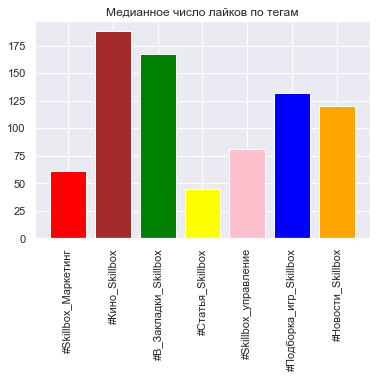

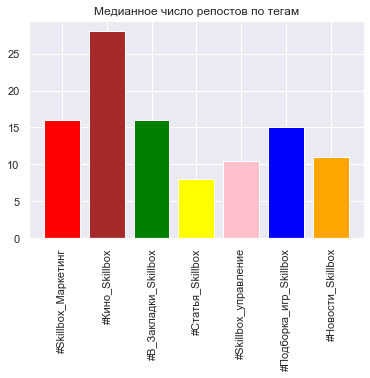

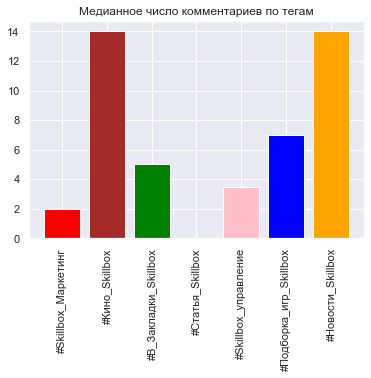

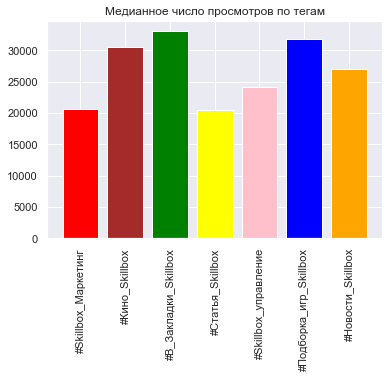

In [133]:
# построим графики

x = ['#Skillbox_Маркетинг','#Кино_Skillbox','#В_Закладки_Skillbox'
    ,'#Статья_Skillbox', '#Skillbox_управление', '#Подборка_игр_Skillbox', '#Новости_Skillbox']

y = [mark_median.loc[0, 'likes'], cinema_median.loc[0, 'likes'], 
    teg_median.loc[0, 'likes'], art_median.loc[0, 'likes'], 
    manag_median.loc[0, 'likes'], game_median.loc[0, 'likes'], news_median.loc[0, 'likes']]

clr = ('red', 'brown', 'green', 'yellow', 'pink', 'blue', 'orange')
fig, subplot = plt.subplots()
subplot.bar(x, y, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число лайков по тегам')


y = [mark_median.loc[0, 'reposts'], cinema_median.loc[0, 'reposts'], 
    teg_median.loc[0, 'reposts'], art_median.loc[0, 'reposts'], 
    manag_median.loc[0, 'reposts'], game_median.loc[0, 'reposts'], news_median.loc[0, 'reposts']]

fig, subplot = plt.subplots()
subplot.bar(x, y, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число репостов по тегам')


y = [mark_median.loc[0, 'comments'], cinema_median.loc[0, 'comments'], 
    teg_median.loc[0, 'comments'], art_median.loc[0, 'comments'], 
    manag_median.loc[0, 'comments'], game_median.loc[0, 'comments'], news_median.loc[0, 'comments']]

fig, subplot = plt.subplots()
subplot.bar(x, y, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число комментариев по тегам')


y = [mark_median.loc[0, 'views'], cinema_median.loc[0, 'views'], 
    teg_median.loc[0, 'views'], art_median.loc[0, 'views'], 
    manag_median.loc[0, 'views'], game_median.loc[0, 'views'], news_median.loc[0, 'views']]

fig, subplot = plt.subplots()
subplot.bar(x, y, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число просмотров по тегам')

plt.show()

**Результат**

В процессе работы мы выяснили:

- аномально высокий интерес у пользователей к определенным постам вероятнее всего носит случайный характер. Такие посты лучше удалить из выборки;
- за выбранный период в 31 день взаимосвязи между "Черной Пятницой" и постами не было;
- самые популярные посты опубликованы в обеденный перерыв с 14 до 15;
- самый большой интерес вызывают пост с тегами '#Кино_Skillbox', '#В_Закладки_Skillbox';
- больше всего обсуждают '#Кино_Skillbox', '#Новости_Skillbox'

Таким образом, SMM-отделу Skillbox можно рекомендовать продолжать делать упор на полезный контент (например, уход за глазами, осанкой и т.д.), а также обсуждение неоднозначных дизайнов, фильмов и фактов и анонсы бесплатных интенсивов.

Чтобы повысить интерес у платёжеспособной аудитории, предлагаю обратить внимание на такие темы, как бизнес, электроника, авто, медицина, недвижимость. 
Я думаю, что нужно подвязывать эти темы через призму, что обучение - это ключ к возможностям обрести желаемое. Будь то собственный бизнес, IPhone последней модели и долгожданная квартира.